In [ ]:
!pip install transformers
!pip install torch
!pip install xformers

In [1]:
## Load data

import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
from transformers import pipeline
import pandas as pd

2023-05-24 00:26:28.645616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 00:26:32.030920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-24 00:26:32.031147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

### Sentiment Analysis using Transformers - distilroberta-finetuned-financial-news-sentiment-analysis

In [9]:
%%time

df_news = pd.read_parquet('02_clean_df.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 4s, sys: 9.19 s, total: 1min 13s
Wall time: 53.1 s


(198564, 7)

In [10]:
df_news['clean_text_sent'] = df_news['clean_text'].parallel_apply(lambda words: ' '.join(words))

In [ ]:
from tqdm import tqdm

def classify_sentiment(text):
    # Split or truncate the text if it exceeds the maximum sequence length
    max_seq_length = 512
    if len(text) > max_seq_length:
        text = text[:max_seq_length]
    
    result = classifier(text)
    return result[0]['label']

# Apply the classification to the dataframe with progress tracker
tqdm.pandas()
df_news['sentiment_text'] = df_news['clean_text_sent'].progress_apply(classify_sentiment)

# Print the dataframe
print(df_news)


In [ ]:
from tqdm import tqdm

def classify_sentiment(text):
    # Split or truncate the text if it exceeds the maximum sequence length
    max_seq_length = 512
    if len(text) > max_seq_length:
        text = text[:max_seq_length]
    
    result = classifier(text)
    return result[0]['label']

# Apply the classification to the dataframe with progress tracker
tqdm.pandas()
df_news['sentiment_text'] = df_news['clean_text_sent'].progress_apply(classify_sentiment)

# Print the dataframe
print(df_news)


In [16]:
from tqdm import tqdm

def classify_sentiment(text):
    # Split or truncate the text if it exceeds the maximum sequence length
    max_seq_length = 512
    if len(text) > max_seq_length:
        text = text[:max_seq_length]
    
    result = classifier(text)
    return result[0]['label'], result[0]['score']

def classify_sentiment_chunk(chunk):
    chunk[['sentiment_label', 'sentiment_score']] = chunk['clean_text_sent'].apply(classify_sentiment).apply(pd.Series)

    #chunk[['sentiment_label', 'sentiment_score']]  = chunk['clean_text_sent'].apply(classify_sentiment)
    return chunk

# Set the chunk size
chunk_size = 5000

# Split the dataframe into chunks
chunks = [df_news[i:i+chunk_size].copy() for i in range(0, len(df_news), chunk_size)]

# Apply the sentiment classification to each chunk with progress tracker
tqdm_chunks = tqdm(chunks, total=len(chunks))
processed_chunks = []
for chunk in tqdm_chunks:
    processed_chunk = classify_sentiment_chunk(chunk)
    processed_chunks.append(processed_chunk)

# Concatenate the processed chunks back into a single dataframe
df_processed = pd.concat(processed_chunks)

# Print the dataframe
print(df_processed)


100%|██████████| 40/40 [2:06:21<00:00, 189.54s/it]  

             date                                              title  \
0      2021-03-18  Artificial intelligence improves parking effic...   
1      2020-02-27  Children With Autism Saw Their Learning and So...   
2      2021-03-26  Forget ML, AI and Industry 4.0 – obsolescence ...   
3      2021-03-10  Strategy Analytics: 71% of Smartphones Sold Gl...   
4      2020-10-20  Olympus to Support Endoscopic AI Diagnosis Edu...   
...           ...                                                ...   
200327 2020-12-14  Comviva and Ooredoo Kuwait form strategic part...   
200328 2020-04-15  AFP used Clearview AI facial recognition softw...   
200329 2020-12-22  From data to knowledge and AI via graphs: Tech...   
200330 2020-10-07  [YS Learn] From helping diabetic patients to m...   
200331 2021-05-06  Startups fight COVID-19: Slang Labs is using v...   

                                                     text year_month  \
0       \n\nArtificial intelligence improves parking e...    20

In [21]:
df_processed.to_parquet('06_sent_trans_df.parquet')

In [3]:
%%time

df_processed = pd.read_parquet('06_sent_trans_df.parquet', engine='pyarrow')
df_processed.shape

CPU times: user 1min 11s, sys: 21 s, total: 1min 32s
Wall time: 1min 25s


(198564, 10)

In [4]:
df_processed['sentiment_label'].value_counts()

sentiment_label
neutral     163900
positive     30254
negative      4410
Name: count, dtype: int64

In [5]:

# Convert the 'year_month' column to datetime format
df_processed['formatted_date'] = pd.to_datetime(df_processed['year_month'].astype(str) + '-01').dt.to_period('M').dt.to_timestamp()

# Use the 'dt' accessor to extract the month and year, and format it as "Jan 2019"
df_processed['year_month'] = df_processed['year_month'].dt.strftime('%b %Y')


In [7]:
print('Total number of rows: ',df_processed.shape[0])

## Dropping duplicate news articles
df1 = df_processed.drop_duplicates(subset=['clean_text_sent'], keep='first', inplace=False)
print('Drop text dups: ',df1.shape[0])

## Dropping news titles that report articles with the same sentiment
df2 = df1.drop_duplicates(subset=['title','sentiment_label'], keep='first', inplace=False)
print('Drop title, sentiment dups: ',df2.shape[0])

Total number of rows:  198564
Drop text dups:  197812
Drop title, sentiment dups:  141130


In [19]:
df2.sample(3)

,date,title,text,year_month,clean_text_case,clean_text,clean_title,clean_text_sent,sentiment_label,sentiment_score,formatted_date,year_month_utd
73512,2021-03-06,Disparate agencies encountering similar lesson...,\n\nDisparate agencies encountering similar le...,Mar 2021,"[Disparate, agency, encountering, similar, les...","[disparate, agency, encountering, similar, les...",disparate agency encountering similar lesson p...,disparate agency encountering similar lesson p...,negative,0.948426,2021-03-01,2021-03
27461,2021-10-24,Machine Learning in Manufacturing Market Proje...,\nMachine Learning in Manufacturing Market Pro...,Oct 2021,"[Machine, Learning, Manufacturing, Market, Pro...","[machine, learning, manufacturing, market, pro...",machine learning manufacturing market projecti...,machine learning manufacturing market projecti...,neutral,0.999829,2021-10-01,2021-10
19435,2021-09-22,Cogniteam Raises $4.2 Million to Bring AI Drag...,\n\nCogniteam Raises $4.2 Million to Bring AI ...,Sep 2021,"[Cogniteam, Raises, 42, Million, Bring, AI, Dr...","[cogniteam, raises, 42, million, bring, ai, dr...",cogniteam raise 42 million bring ai draganddro...,cogniteam raises 42 million bring ai draganddr...,neutral,0.999876,2021-09-01,2021-09


In [42]:
# Extract the year and month from the 'date' column
df2['year_month_utd'] = df2['date'].dt.to_period('M')


/var/tmp/ipykernel_32096/2111894942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_month_utd'] = df2['date'].dt.to_period('M')


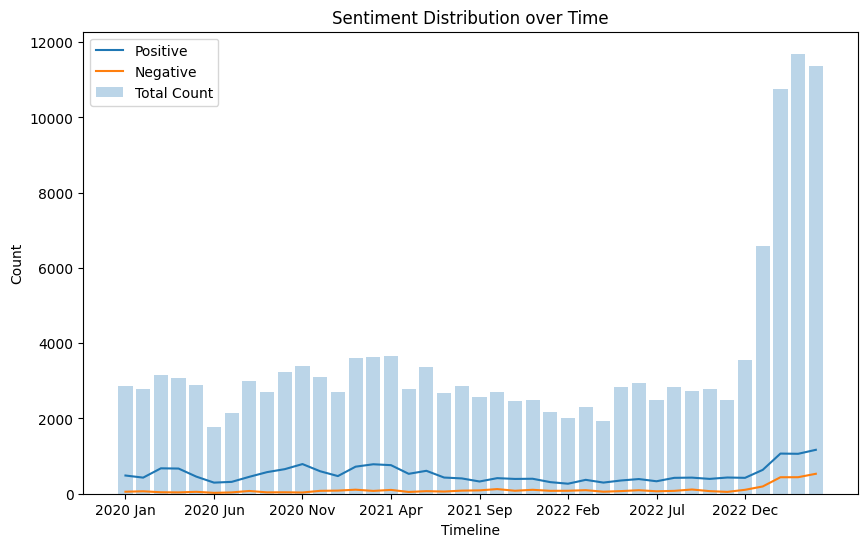

In [47]:
import matplotlib.pyplot as plt
# Group the DataFrame by 'year_month' and 'sentiment_label', and calculate the counts
grouped = df2.groupby(['year_month_utd', 'sentiment_label']).size().unstack(fill_value=0)


# Calculate the total count for each time period
total_counts = grouped.sum(axis=1)

from datetime import datetime
# Convert the grouped data to separate lists for positive, negative, and neutral sentiments
timeline = grouped.index.astype(str).tolist()
timeline = [datetime.strptime(date_str, "%Y-%m").strftime("%Y %b") for date_str in timeline]

#timeline = sorted(timeline, key=lambda x: pd.to_datetime(x, format='%Y %b'))

positive_sentiment = grouped['positive'].tolist()
negative_sentiment = grouped['negative'].tolist()
neutral_sentiment = grouped['neutral'].tolist()

plt.figure(figsize=(10, 6))  
# Bar plot for total count
plt.bar(timeline, total_counts, alpha=0.3, label='Total Count')

# Line plot
plt.plot(timeline, positive_sentiment, label='Positive')
plt.plot(timeline, negative_sentiment, label='Negative')
#plt.plot(timeline, neutral_sentiment, label='Neutral')


plt.xlabel('Timeline')
plt.ylabel('Count')
plt.title('Sentiment Distribution over Time')
plt.legend()
plt.xticks(timeline[::5], rotation=0) 
plt.show()

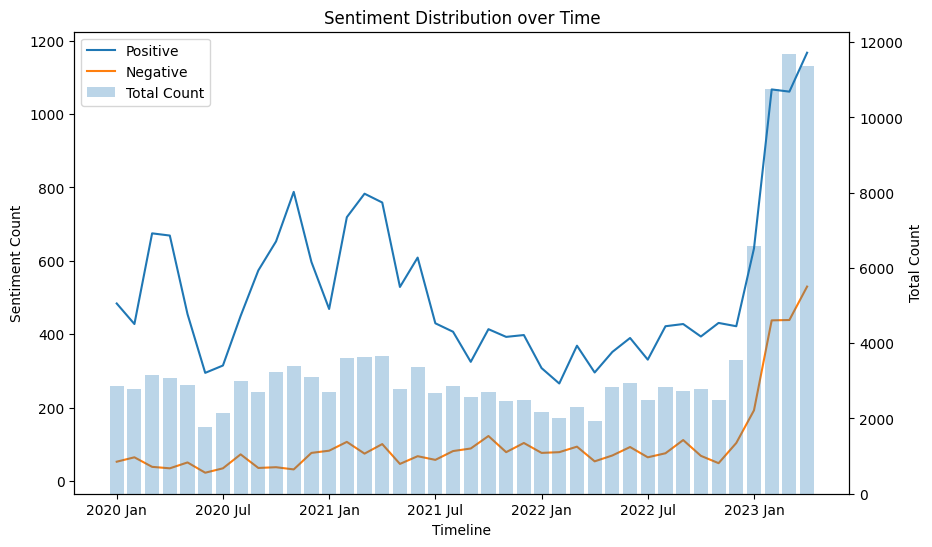

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt

# Bar plot for total count
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax2.bar(timeline, total_counts, alpha=0.3, label='Total Count')

# Line plot
ax1.plot(timeline, positive_sentiment, label='Positive')
ax1.plot(timeline, negative_sentiment, label='Negative')


# Set labels and title
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Sentiment Count')
ax2.set_ylabel('Total Count')
ax1.set_title('Sentiment Distribution over Time')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

# Rotate x-axis tick labels
plt.xticks(timeline[::6], rotation=45)

# Display the plot
plt.show()
plt.savefig('Sentiment_Distribution_over_Time.jpeg')


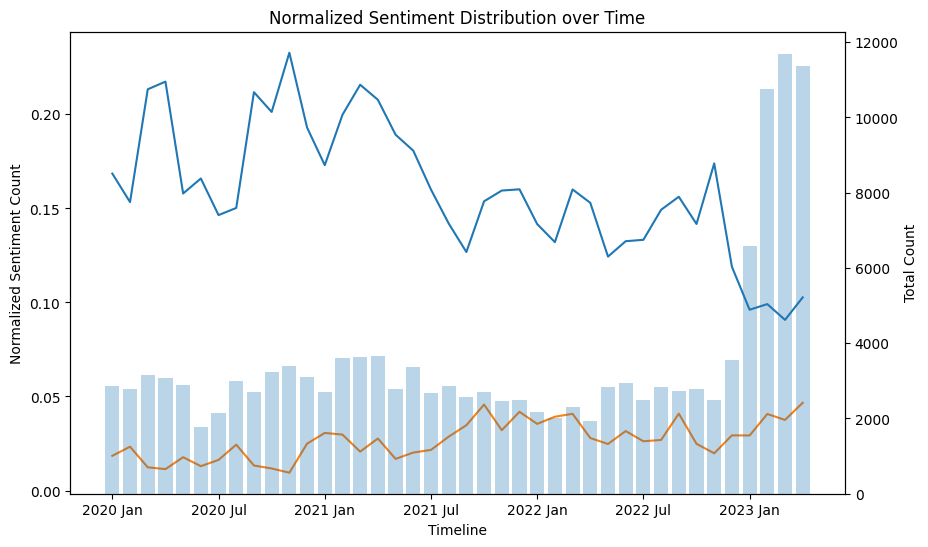

In [49]:

# Calculate the total count for each time period
total_counts = grouped.sum(axis=1)


# Calculate the normalized sentiment values
normalized_positive_sentiment = grouped['positive'] / total_counts
normalized_negative_sentiment = grouped['negative'] / total_counts
normalized_neutral_sentiment = grouped['neutral'] / total_counts


# Bar plot for total count
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax2.bar(timeline, total_counts, alpha=0.3, label='Total Count')

# Line plot
ax1.plot(timeline, normalized_positive_sentiment, label='Positive')
ax1.plot(timeline, normalized_negative_sentiment, label='Negative')

# Set labels and title
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Normalized Sentiment Count')
ax2.set_ylabel('Total Count')
ax1.set_title('Normalized Sentiment Distribution over Time')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2)

# Rotate x-axis tick labels
plt.xticks(timeline[::6], rotation=45)

# Display the plot
plt.show()


In [10]:
df_pos = df_processed[df_processed['sentiment_label'] == 'positive']
df_neg = df_processed[df_processed['sentiment_label'] == 'negative']